Este notebook servirá para calcular la masa del solitón para unos parámetros dados y obtener un cierto conjunto de gráficas (principalmente las densidades de energía). Además, luego sacaremos lo análogo para los momentos de inercia.

Para ver en más detalle cómo funciona, ir al notebook de Buscaminimos.

In [12]:
#Importamos las librerias.
import numpy as np
from numba import njit
import matplotlib.pyplot as plt
import matplotlib as mpl
import math
import scipy.integrate as integrate

#Proporciones y tamaños en las graficas.
params = {'xtick.labelsize': 30, 'ytick.labelsize': 20, 'font.size': 30}#
mpl.rcParams.update(params)

#Constantes para el calculo (en MeV o adimensionales).
F_pi_val = 128.55 # o 104.8 o 186
e_val = 6.275 # o 4.84
m_pi = 138
alpha = 0.0444
m_rho = 796
kapp_inv = 0.0297

#Valores correctos
M_N_corr = 939 #MeV
M_D_corr = 1232 #MeV
r_bar_corr = 0.72 #fm

#Factores de conversion de longitud y energia.
Factor_l = (2/(e_val *F_pi_val))
Factor_e = F_pi_val/(4*e_val)* (12*np.pi**2)

convers = 806554.815355*10**6 * (2*np.pi) #1MeV = ... m^-1

n_r = 500 #500
r_f = 30. #30
n_lam = 100 #100
lam_f = np.sqrt(3.8) + 0.1

rs = np.linspace(1e-6, r_f, n_r)* Factor_l
rs2 = np.linspace(1e-6, r_f, 2000)* Factor_l
lams3 = np.linspace((lam_f-0.5*2), lam_f, 4)**2* Factor_l**2
lams = np.linspace((lam_f-0.1*2), lam_f, n_lam)**2* Factor_l**2

In [13]:
@njit
def Mskyrme(F_pi_val, lam, m_pi, e_val):
    return 6.336630541*F_pi_val**2*np.sqrt(lam) + 53.4570253/(e_val**2*np.sqrt(lam))# + 2*np.pi*73.5595*F_pi_val**2*m_pi**2 *np.sqrt(lam)**3

1.2796953710483658


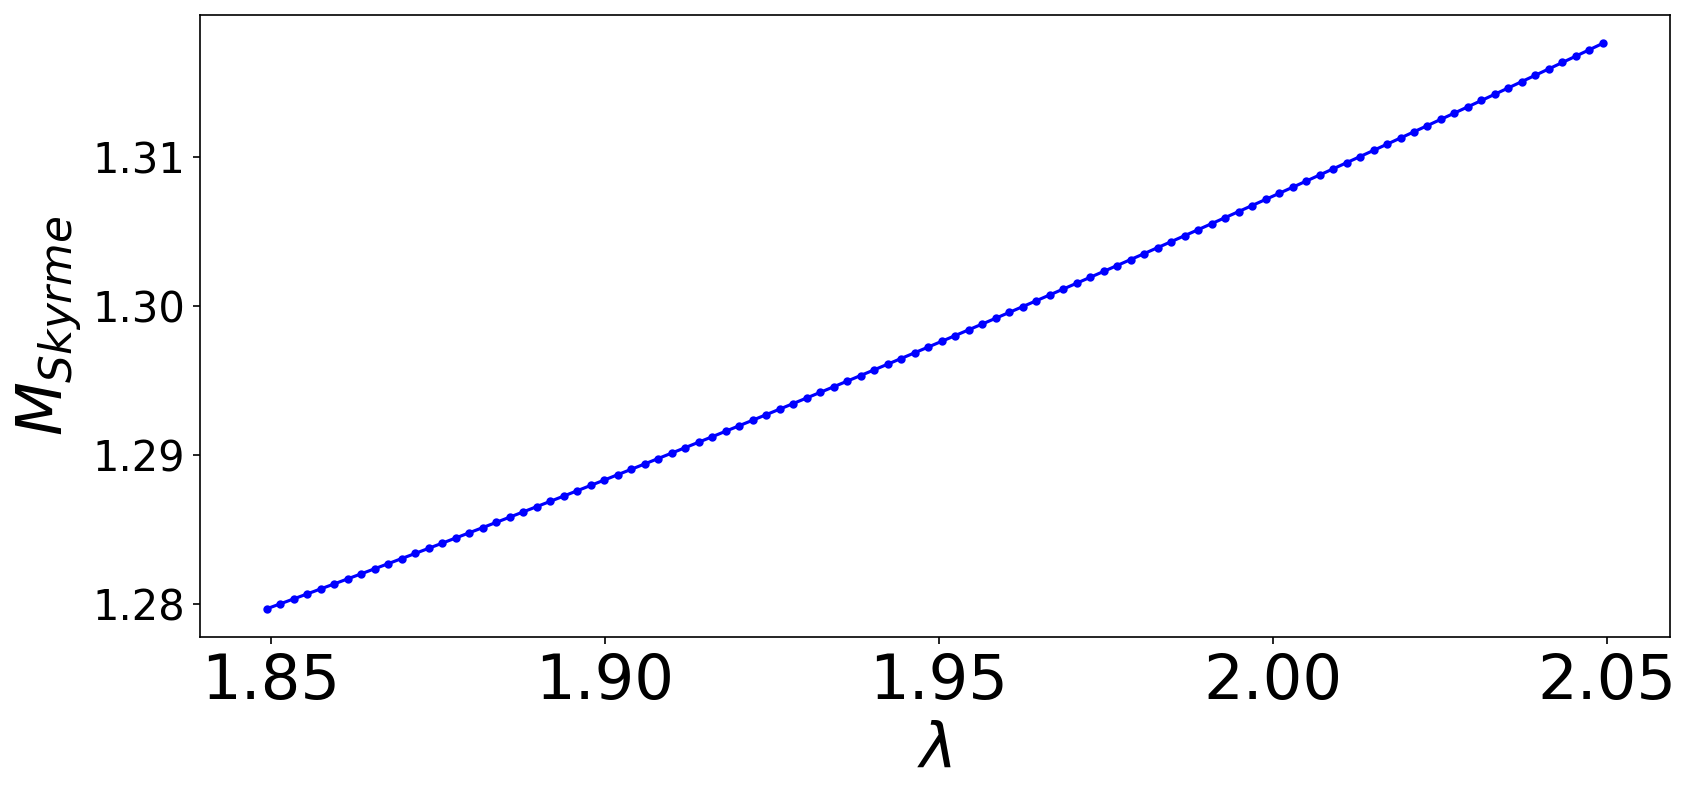

In [14]:
Masas_skyrme = np.array([Mskyrme(F_pi_val, _lam, m_pi, e_val) for _lam in lams])/Factor_e
print(min(Masas_skyrme))

plt.figure('MasasSkyrme', figsize=(12, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, Masas_skyrme, '.-b')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$M_{Skyrme}$')
plt.tight_layout(); plt.show()

Densidad radial de energía.

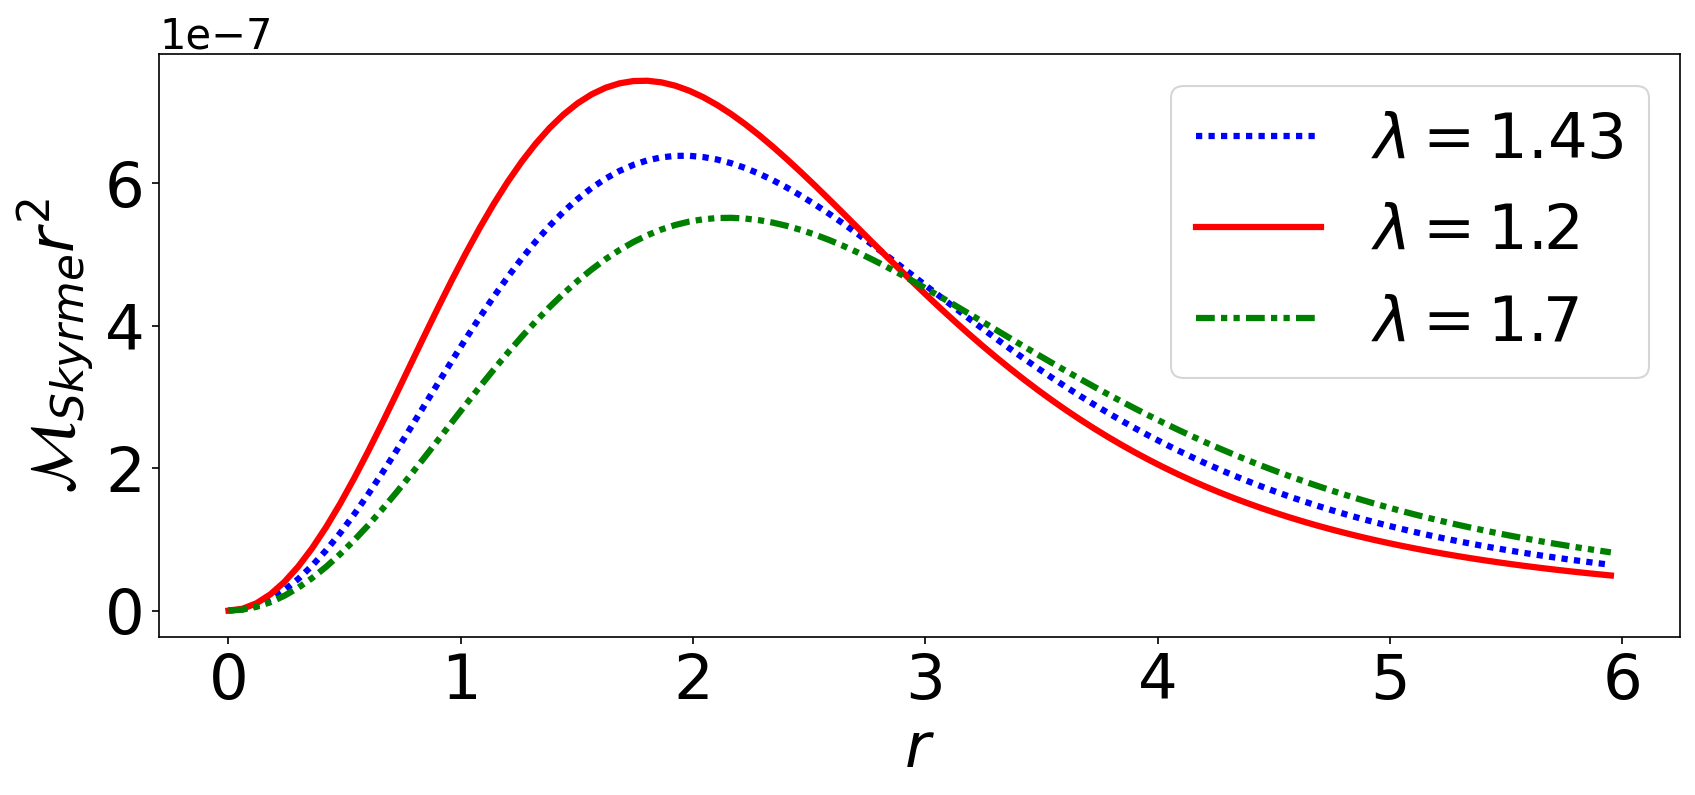

In [15]:
@njit
def Mskyrmr(r, F_pi_val, lam, m_pi, e_val):
    a = (lam+r*r); sinus = np.sin(np.pi * r / np.sqrt(a))**2
    return (F_pi_val**2 / 4 * ( np.pi**2 * lam**2 / 2*a**3 + sinus/r**2) + ( np.pi**2 * lam**2 * sinus/a**3 + sinus**2 /(2*r*r) ) / (e_val*r)**2)*r**2

Masas_skyrmer1 = np.array([Mskyrmr(_r, F_pi_val, 1.43*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3
Masas_skyrmer2 = np.array([Mskyrmr(_r, F_pi_val, 1.2*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3
Masas_skyrmer3 = np.array([Mskyrmr(_r, F_pi_val, 1.7*Factor_l**2, m_pi, e_val) for _r in rs2])/Factor_e * Factor_l**3

plt.figure('MasasSkyrme', figsize=(12, 6), dpi=150)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer1[:int(len(rs2)/20)], 'b', linestyle = (0, (1, 1)), label = r'$\lambda=${}'.format(1.43), linewidth=3)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer2[:int(len(rs2)/20)], '-r', label = r'$\lambda=${}'.format(1.2), linewidth=3)
plt.plot(rs[:int(len(rs2)/20)] / Factor_l, Masas_skyrmer3[:int(len(rs2)/20)], '-g', linestyle = (0, (3, 1, 1, 1, 1, 1)), label = r'$\lambda=${}'.format(1.7), linewidth=3)

plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{M}_{Skyrme} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc= 'upper right')
plt.tight_layout(); plt.show()

In [16]:
@njit
def M4_dif(k11, k12, k31, k32, dr, r):
    dk1 = (k12-k11)/dr; dk3 = (k32-k31)/dr; k1r = (k12+k11)/2; k3r = (k32+k31)/2#Definimos tanto las derivadas (dk1, dk3) como los valores medios entre los dos puntos(k1r, k3r)
    return (k1r + r*dk1)**2 + 3*k3r**2 + 2*r*k3r*dk3 + dk3**2 * r**2
@njit
def M5_dif(k1, k3, r): return (k1**2 + k3**2)*r**2
@njit
def M6_dif(k31, k32, dr, r, lam):
    dk3 = (k32-k31)/dr; k3r = (k32+k31)/2; a = np.sqrt(lam+r**2)
    return np.sin(np.pi*r/a) / (r*a**3) * ( 2*np.pi*lam*r*(k3r+r*dk3)  + k3r*a**3*np.sin(2*np.pi*r/a) )
@njit
def integrador4(k1, k3, rs):
    dr = rs[1] - rs[0]; M4 = 0
    for i in range(len(rs)-1): M4 += M4_dif(k1[i], k1[i+1], k3[i], k3[i+1], dr, (rs[i]+rs[i+1])/2 ) * dr#Vamos a cada punto y evaluamos el integrando
    return M4*4.*np.pi
@njit
def integrador5(k1, k3, rs):
    dr = rs[2] - rs[1]; M5 = 0
    for i in range(len(rs)): M5 += M5_dif(k1[i], k3[i], rs[i]) * dr#Vamos a cada punto y evaluamos el integrando
    return M5*4.*np.pi
@njit
def integrador6(k3, rs, lam):
    dr = rs[2] - rs[1]; M6 = 0
    for i in range(len(rs)-1): M6 += M6_dif( k3[i], k3[i+1], dr, (rs[i]+rs[i+1])/2, lam ) * dr#Vamos a cada punto y evaluamos el integrando
    return M6*16.*np.pi
@njit
def M7(F_pi_val, lam, kapp_inv): return 4*np.pi**3 * 1.35209 * kapp_inv**2/ (np.sqrt(lam)**3 *F_pi_val**2)

@njit
def dens_M7(F_pi_val, lam, kapp_inv, r): return 4*np.pi**3*kapp_inv**2 *lam/(F_pi_val**2) * np.sin(np.pi*r/np.sqrt(lam+r*r))**4 / (r*r*(r*r+lam)**3)

Densidad radial de energía.

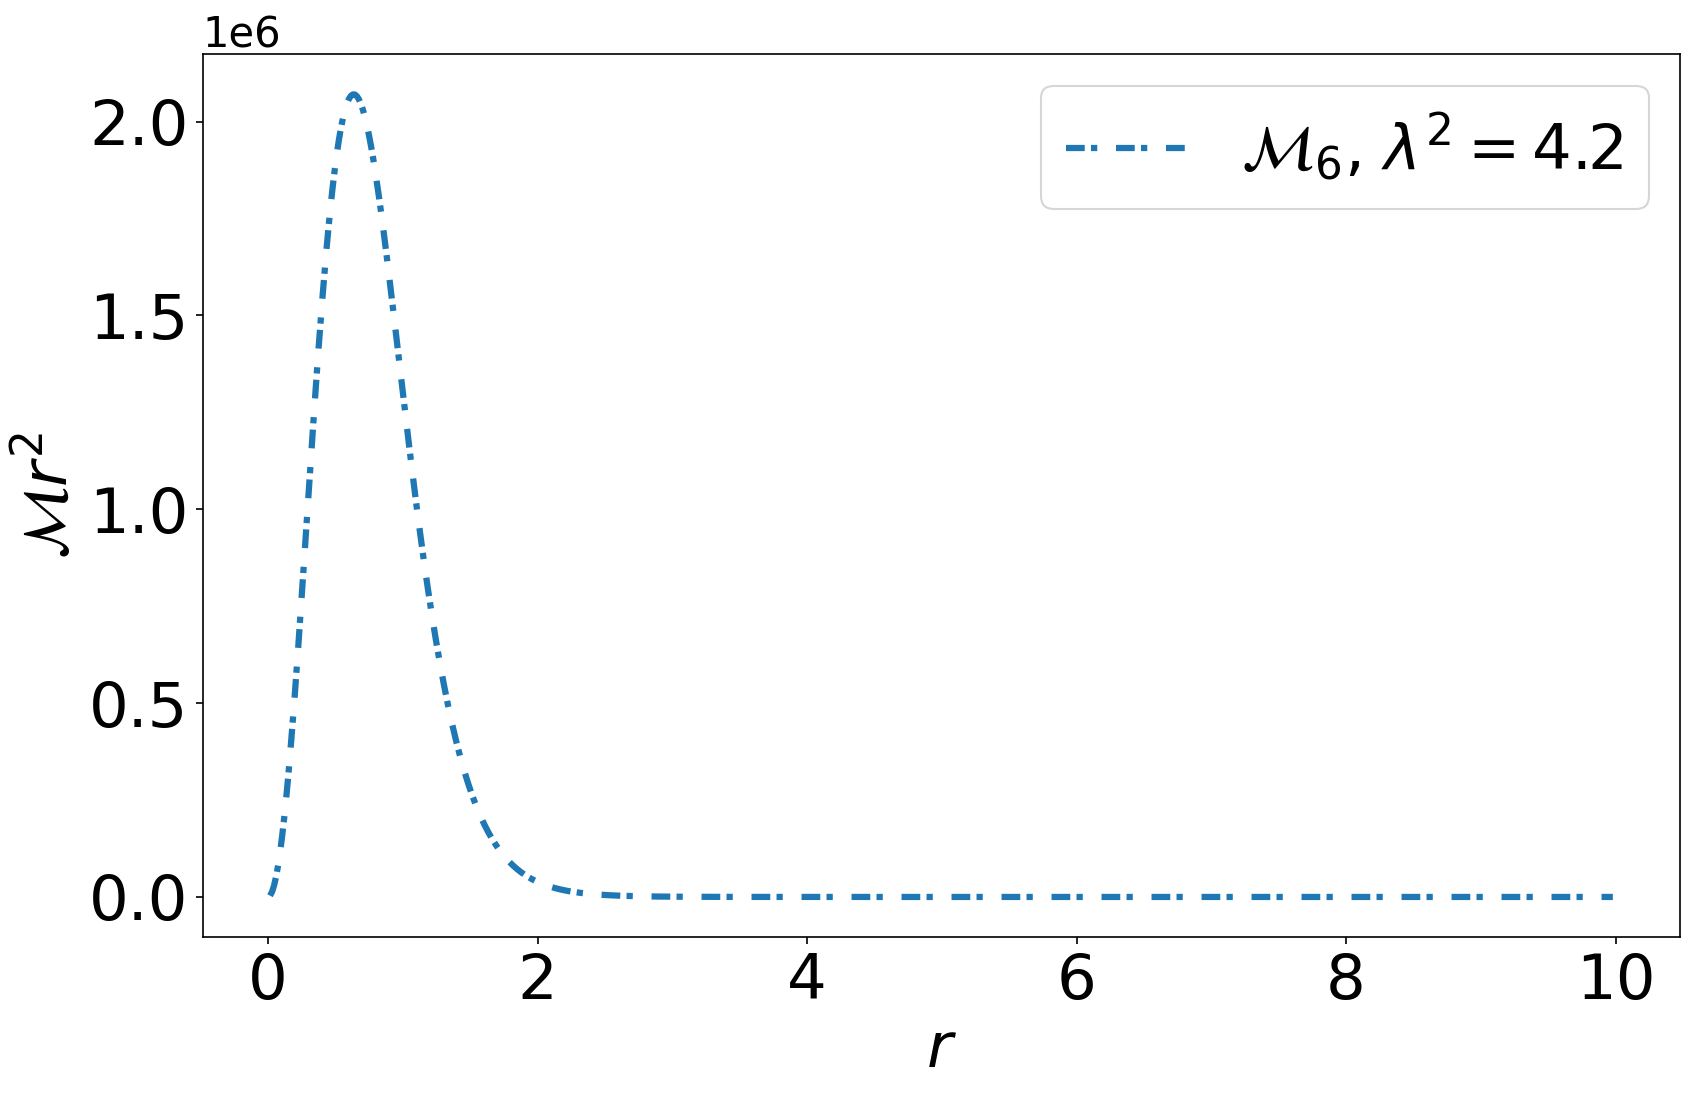

In [17]:
dr2 = rs2[1] - rs2[0]
M_7_dif = np.array([ dens_M7(F_pi_val, lams3[-1], kapp_inv, rs2[_r]) for _r in range(len(rs2)-1) ])/Factor_e

labels2 = [ ', $\lambda^2=${0}'.format(round(lams3[0]/Factor_l**2, 1)), ', $\lambda^2=${0}'.format(round(lams3[-1]/Factor_l**2, 1))]
labels3 = [ ', $\lambda^2=${0}'.format(round(lams3[0]/Factor_l**2, 1)), ', $\lambda^2=${0}'.format(round(lams3[int(len(lams3)/4)]/Factor_l**2, 1))]
plt.figure('Mi frente a r', figsize=(12, 8), dpi = 150)

plt.plot(rs2[1:int(len(rs2)/3)] / Factor_l, M_7_dif[1:int(len(rs2)/3)], linestyle=(0, (3, 1, 1, 3)), label=r'$\mathcal{M}_6$'+labels2[1], linewidth=3)
plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{M} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize = 30)
plt.tight_layout(); plt.show()


In [18]:
Masas_7 = np.array([M7(F_pi_val,  _lam, kapp_inv) for _lam in lams]) / Factor_e
Masas_skyrme2 = np.array([Mskyrme(F_pi_val, _lam, m_pi, e_val) for _lam in lams])/Factor_e

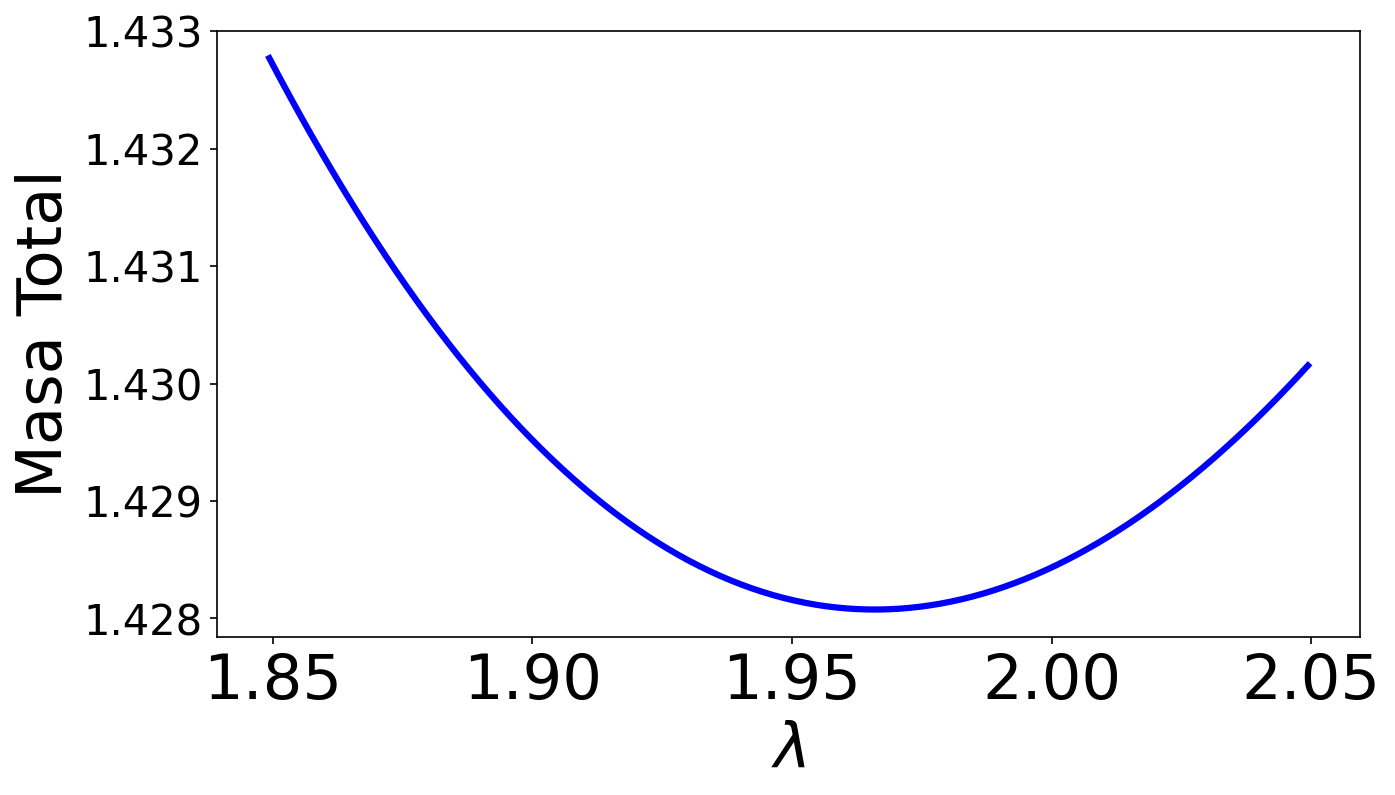

In [19]:
plt.figure('Masas', figsize=(10, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, Masas_skyrme2+Masas_7, '-b', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel('Masa Total')
plt.tight_layout(); plt.show()

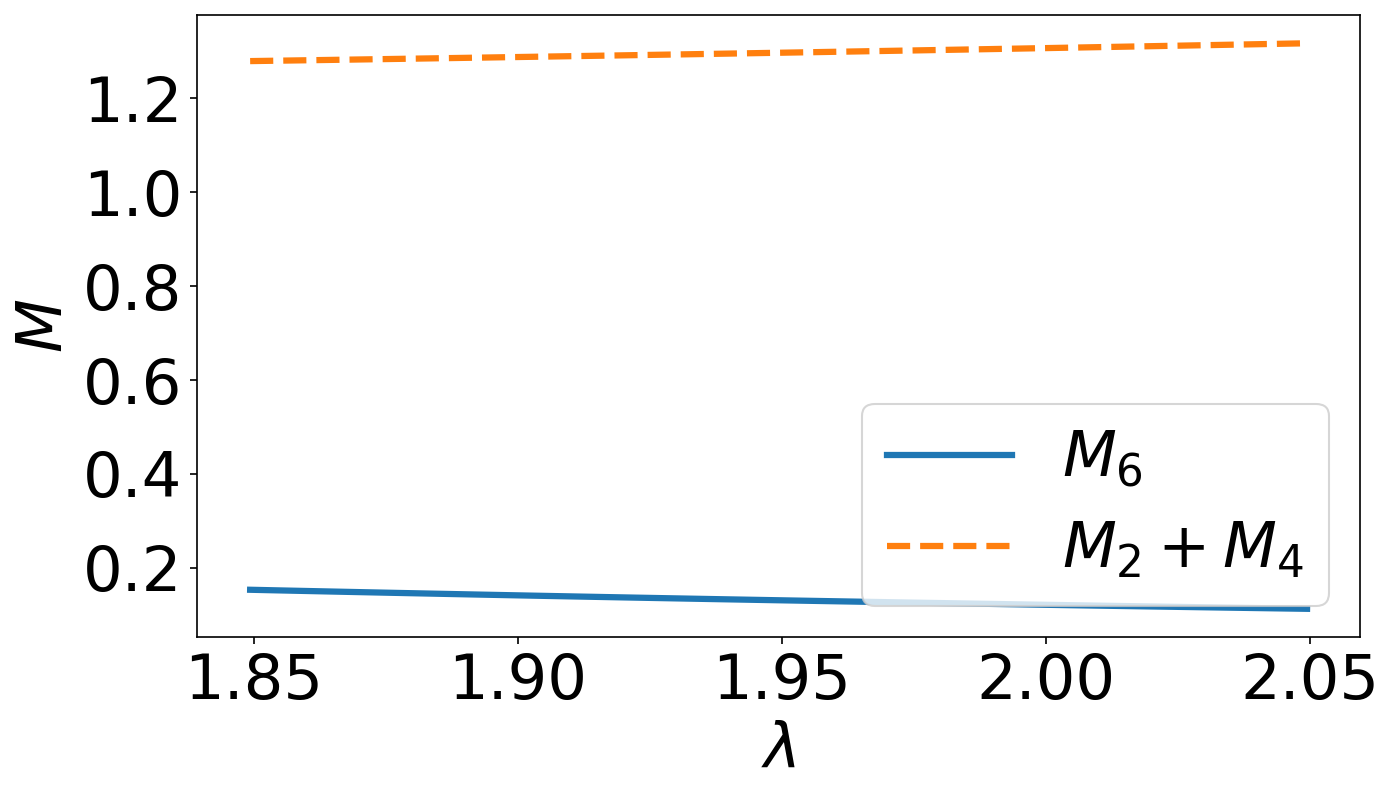

In [20]:
plt.figure('M7', figsize=(10, 6), dpi=150)
plt.plot(np.sqrt(lams)/ Factor_l, Masas_7, '-', linewidth=3, label=r'$M_6$')
plt.plot(np.sqrt(lams)/ Factor_l, Masas_skyrme2, '--', linewidth=3, label=r'$M_{2}+M_4$')

plt.xlabel(r'$\lambda$'); plt.ylabel('$M$')
plt.legend(loc='lower right')
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

In [21]:
MSkyrm6 = Masas_skyrme2+Masas_7

print('Minimo Skyrme=', min(Masas_skyrme))
print('Minimo Skyrme6=', min(MSkyrm6))

print('lam minimo Skyrme=', np.sqrt(lams[list(Masas_skyrme).index(min(Masas_skyrme))]) / Factor_l)
print('lam minimo Skyrme6=', np.sqrt(lams[list(MSkyrm6).index(min(MSkyrm6))]) / Factor_l)
print('ultimo lambda = ', np.sqrt(lams[-1]) / Factor_l)

Minimo Skyrme= 1.2796953710483658
Minimo Skyrme6= 1.428075727312489
lam minimo Skyrme= 1.8493588689617926
lam minimo Skyrme6= 1.96653058613351
ultimo lambda =  2.0493588689617925


Ahora vamos a movernos a lo largo de h mediante un parámetro H para ver cual es el cambio.

Ahora los momentos de inercia.

In [22]:
@njit
def I12(F_pi_val, e_val, lam): return np.pi*np.sqrt(lam)/(e_val**2)*(9.982 + 516.357*F_pi_val**2*e_val**2*lam)
@njit
def I4(k1, k3, rs): return integrador5(k1, k3, rs)*(4./3.)
@njit
def MI6_dif(k3, dr, r, lam):
    a = np.sqrt(lam+r**2)
    return r*r*np.sin(np.pi*r/a)*k3*( np.sin(2.*np.pi*r/a)/r + 2.*np.pi*lam/a**3)
@njit
def integradorI6(k3, rs, lam):
    dr = rs[2] - rs[1]; M6 = 0
    for i in range(len(rs)): M6 += MI6_dif( k3[i], dr, rs[i], lam ) * dr
    return M6
@njit
def I6(alpha, k1, k3, lam, rs):
    return 32*np.pi/3 * alpha * integradorI6(k3, rs, lam)
@njit
def I7(F_pi_val, kappa_inv, lam): return 1.26611*np.pi**3 *kappa_inv**2/(np.sqrt(lam)*F_pi_val**2) 

In [23]:
I__12 = np.array( [ I12(F_pi_val, e_val, lams[_]) for _ in range(n_lam) ] )
I__7 = np.array( [ I7(F_pi_val, kapp_inv, lams[_]) for _ in range(n_lam) ] )
I__T2 = I__12 + I__7

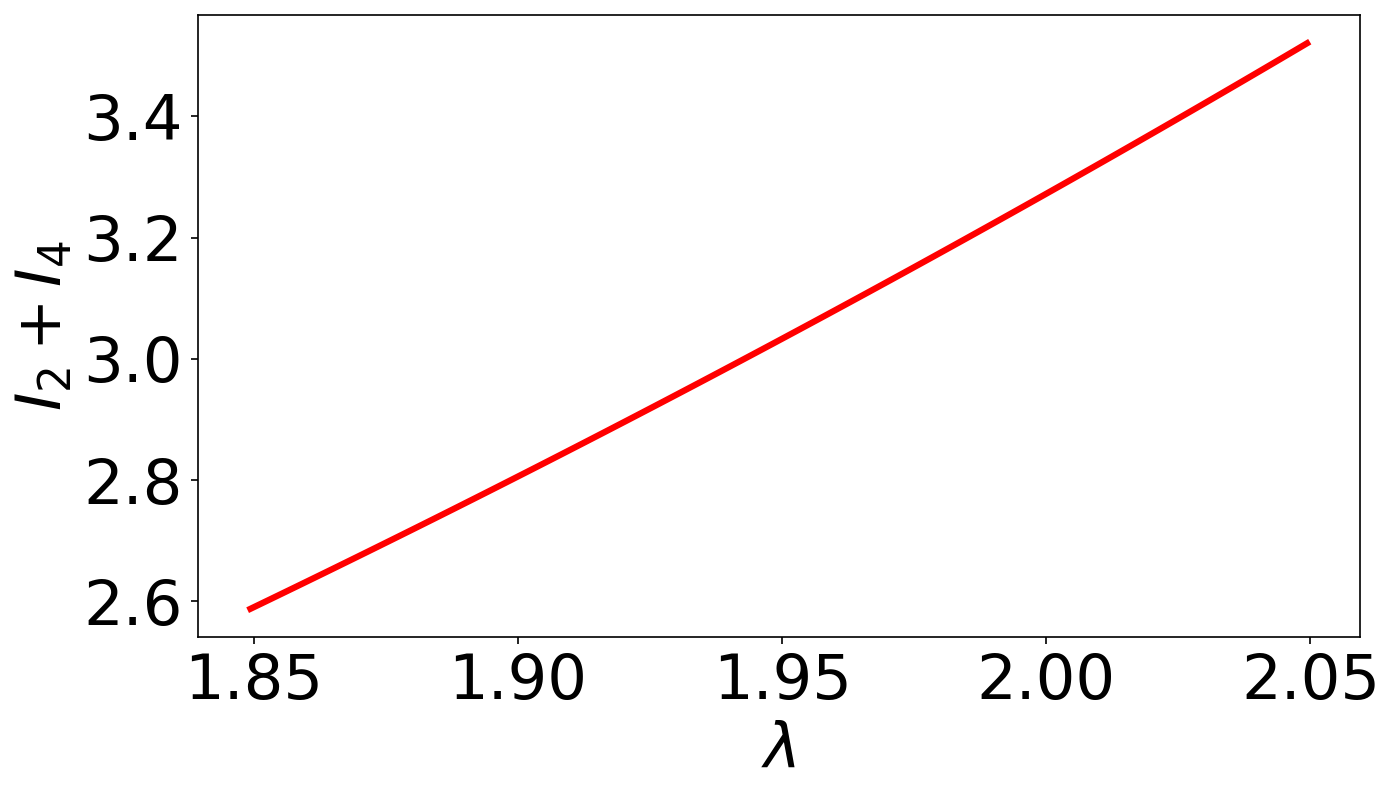

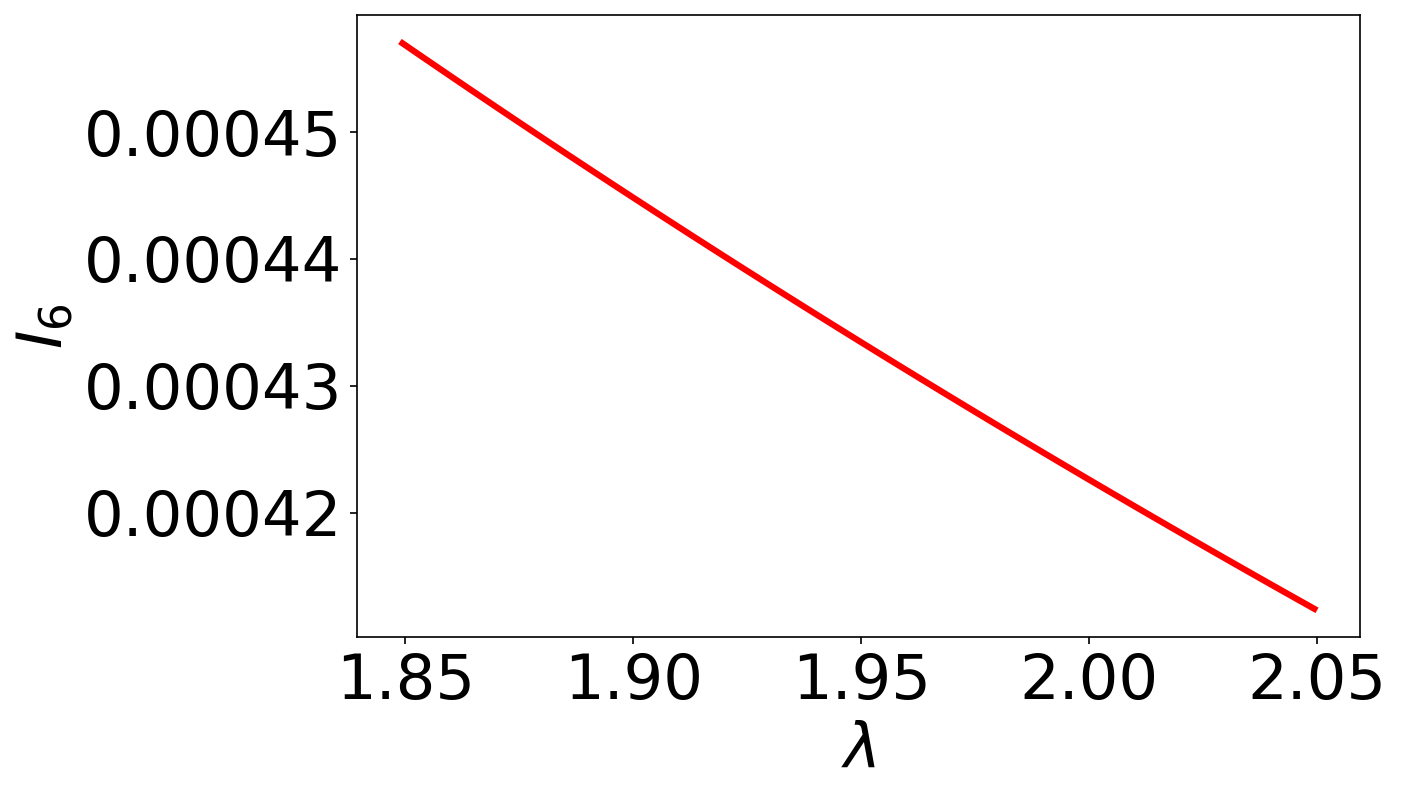

In [24]:
plt.figure('I12', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__12, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_2+I_4$')
plt.yticks(fontsize=30)
plt.tight_layout()

plt.figure('I7', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__7, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_6$')
plt.yticks(fontsize=30)
plt.tight_layout(); plt.show()

In [25]:
@njit
def dens_I_sk(F_pi_val, e_val, lam, r):
    a = np.sqrt(r*r+lam)
    return 8 *np.pi/(3*e_val**2)* np.sin(np.pi*r/a)**2 *(np.sin(np.pi*r/a)**2/r**2 + np.pi**2 *lam**2 /a**6 + (F_pi_val*e_val/2)**2)*r*r
@njit
def dens_I_4(k1, k3, r): return 4/3 *M5_dif(k1, k3, r)
@njit
def dens_I_6(k3, alpha, lam, r):
    a = np.sqrt(r*r+lam)
    return 32*np.pi/3 *alpha *r*r*np.sin(np.pi*r/a)*k3*(np.sin(2*np.pi*r/a)/r + 2*np.pi*lam/a**3)
@njit
def dens_I_7(F_pi_val, kapp_inv, lam, r):
    a = np.sqrt(r*r+lam)
    return 16*np.pi**3*kapp_inv*lam**2 /3 *np.sin(np.pi*r/a)/a**6

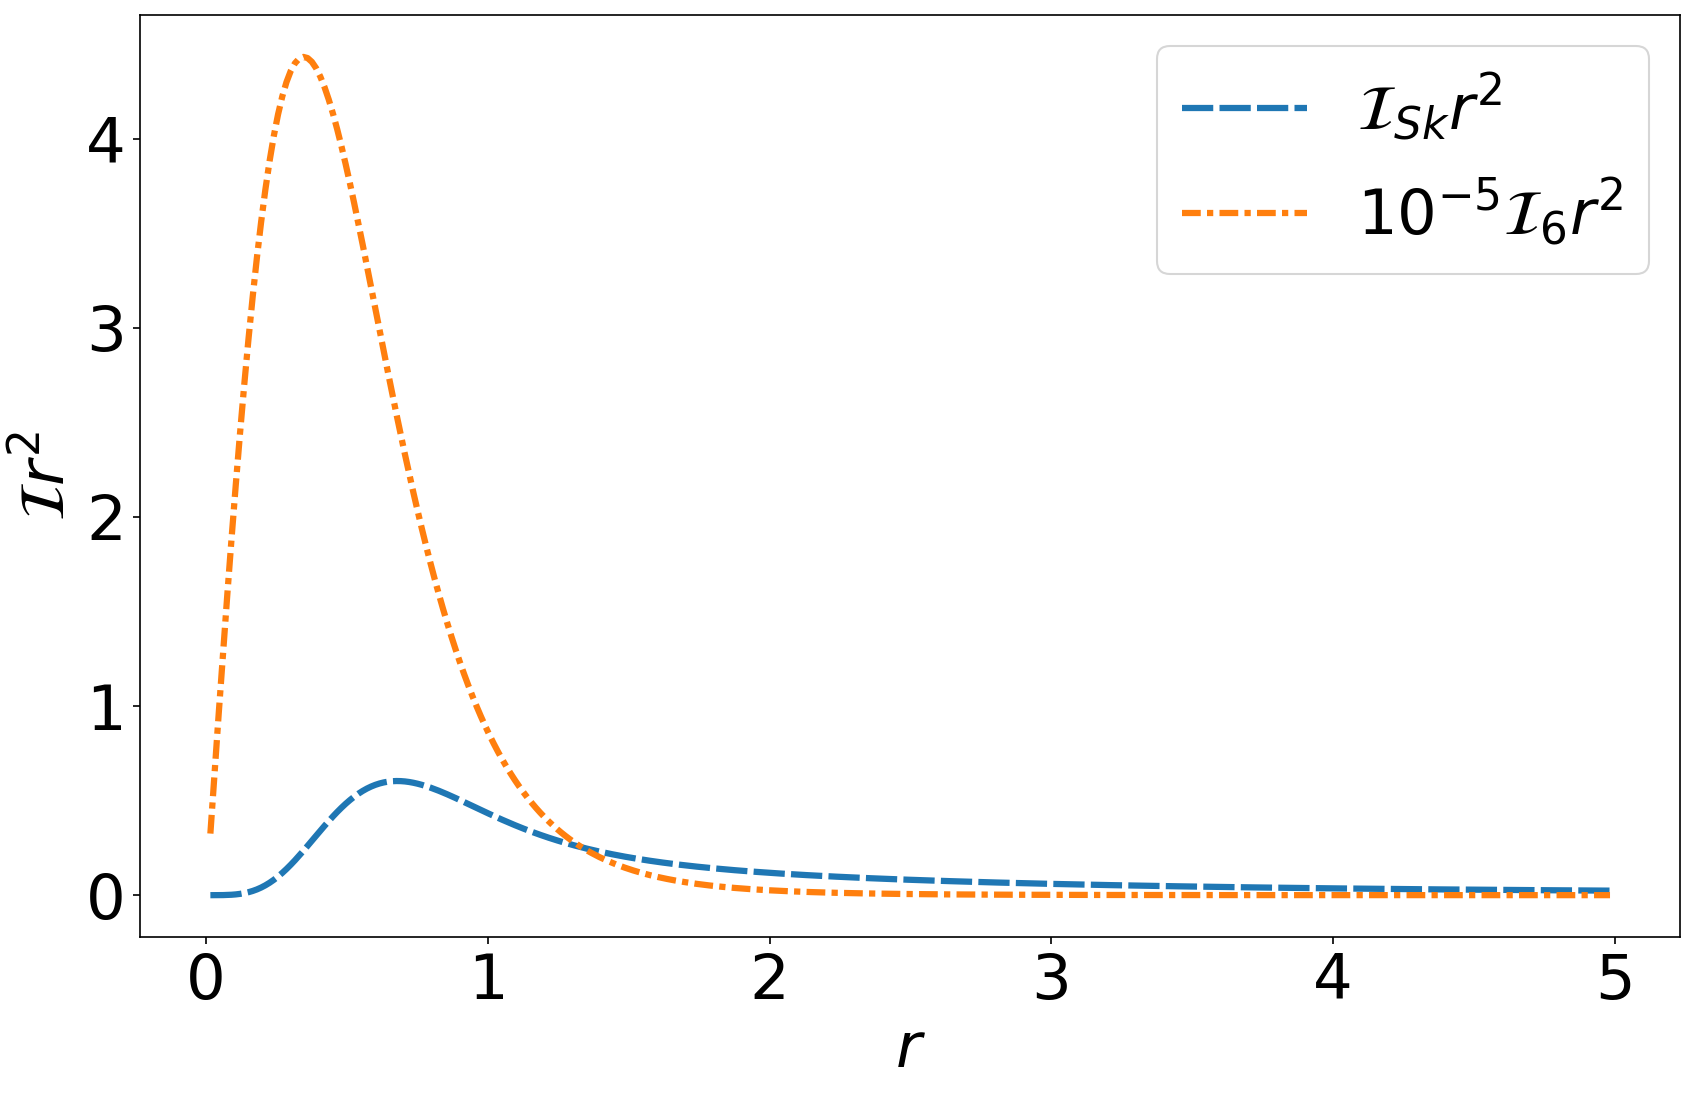

In [26]:
dens_I__12 = np.array( [ dens_I_sk(F_pi_val, e_val, lams3[0], _r) for _r in rs2 ] )
dens_I__7 = np.array( [ dens_I_7(F_pi_val, kapp_inv, lams3[0], rs2[_r]) for _r in range(len(rs2)) ] )

plt.figure('Ii frente a r', figsize=(12, 8), dpi = 150)
plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__12[1:int(len(rs2)/6)], linestyle=(0, (5, 1)), label=r'$\mathcal{I}_{Sk} r^2$', linewidth=3)
plt.plot(rs2[1:int(len(rs2)/6)] / Factor_l, dens_I__7[1:int(len(rs2)/6)]/10**5, linestyle=(0, (3, 1, 1, 1)), label=r'$10^{-5} \mathcal{I}_6 r^2$', linewidth=3)

plt.xlabel(r'$r$'); plt.ylabel(r'$\mathcal{I} r^2$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize = 30)
plt.tight_layout(); plt.show()

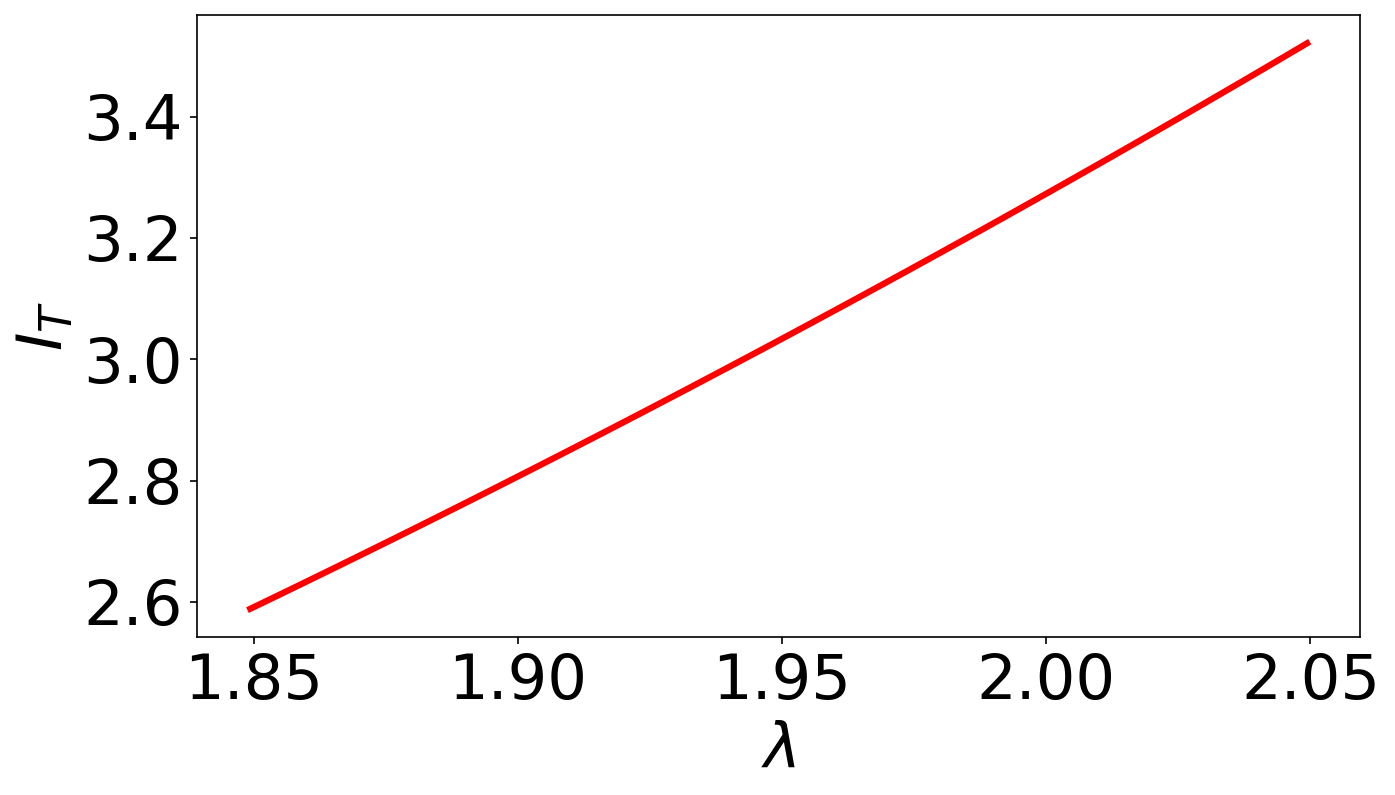

In [27]:
plt.figure('IT2', figsize=(10, 6), dpi = 150)
plt.plot(np.sqrt(lams)/ Factor_l, I__T2, '-r', linewidth=3)

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$I_T$')
plt.yticks(fontsize=30)
plt.tight_layout()

In [28]:
@njit
def rbar(lam): return 0.55718 * lam
@njit
def r_cuad_med_bar(lam, convers): return np.sqrt(rbar(lam))/convers *10**15 #Convertimos a fm

@njit
def rmagn(lam): return 1.809321 * lam 
@njit
def r_cuad_med_magn(lam, convers): return np.sqrt(rmagn(lam))/convers *10**15 #Convertimos a fm

Masa neutron6:  939.33  MeV
Masa delta6:  1231.73  MeV

Radio bar6:  0.7182  fm
Radio magn6:  1.2942  fm

mmag_p6:  2.0104
mmag_n6:  -1.2019


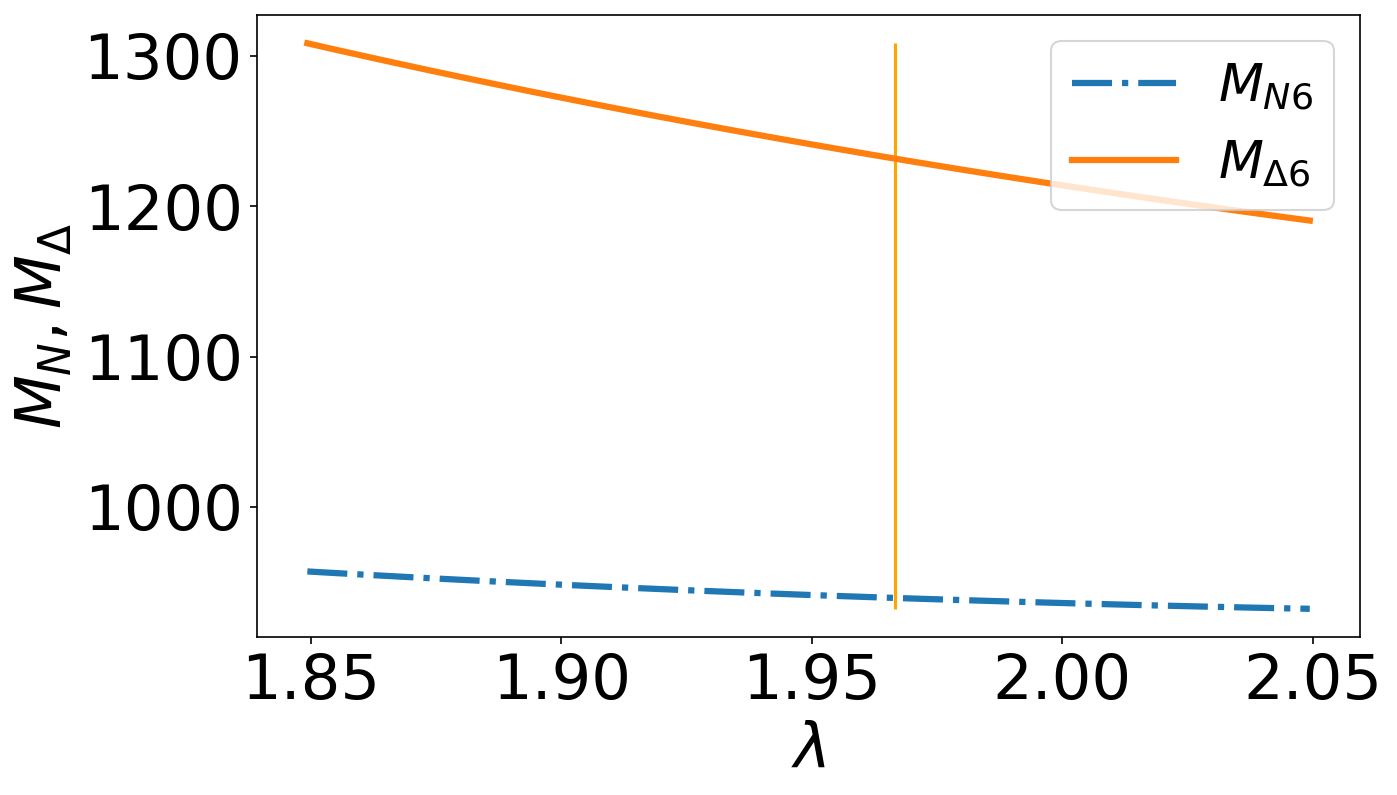

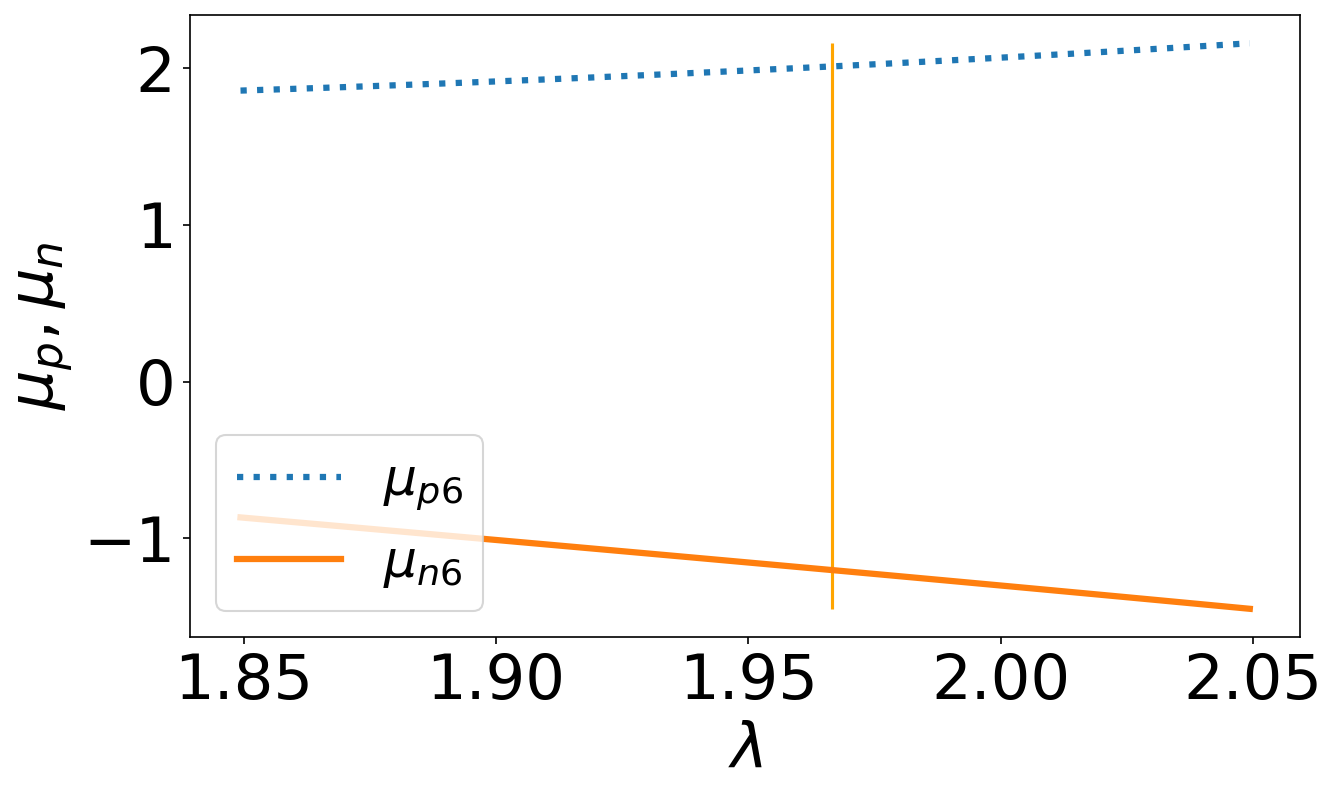

In [33]:
Masas_72 = np.array([M7(F_pi_val, _lam, kapp_inv) for _lam in lams])
MSkyrm62 = Masas_skyrme*Factor_e+Masas_72

index2 = list(MSkyrm62).index(min(MSkyrm62))

lam_min2 = lams[index2]

M_N2 = (MSkyrm62 + 3./(8.*I__T2)*Factor_e)
M_D2 = (MSkyrm62 + 15./(8.*I__T2)*Factor_e)

r_bar2 = r_cuad_med_bar(lam_min2, convers)
r_magn2 = r_cuad_med_magn(lam_min2, convers)

m_magn_p2 = M_N2/3*((r_bar2*convers *10**-15)**2/(2*I__T2)*Factor_e + I__T2/Factor_e)
m_magn_n2 = M_N2/3*((r_bar2*convers *10**-15)**2/(2*I__T2)*Factor_e - I__T2/Factor_e)

plt.figure('M_ND', figsize=(10, 6), dpi = 150)
plt.vlines(np.sqrt(lams[index2])/ Factor_l, min(M_N2), max(M_D2), color='orange')
plt.plot(np.sqrt(lams)/ Factor_l, M_N2, '-.', linewidth=3, label=r'$M_{N6}$')
plt.plot(np.sqrt(lams)/ Factor_l, M_D2, '-', linewidth=3, label=r'$M_{\Delta 6}$')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$M_N, M_\Delta$')
plt.yticks(fontsize=30)
plt.legend(loc='upper right', fontsize=25)
plt.tight_layout()

plt.figure('mu_np', figsize=(10, 6), dpi = 150)
plt.vlines(np.sqrt(lams[index2])/ Factor_l, min(m_magn_n2), max(m_magn_p2), color='orange')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_p2, ':', linewidth=3, label=r'$\mu_{p6}$')
plt.plot(np.sqrt(lams)/ Factor_l, m_magn_n2, '-', linewidth=3, label=r'$\mu_{n6}$')

plt.xlabel(r'$\lambda$'); plt.ylabel(r'$\mu_p, \mu_n$')
plt.yticks(fontsize=30)
plt.legend(loc='lower left', fontsize=25)
plt.tight_layout()


print('Masa neutron6: ', round(M_N2[index2], 2), ' MeV')
print('Masa delta6: ', round(M_D2[index2], 2), ' MeV')
print()

print('Radio bar6: ', round(r_bar2, 4), ' fm')
print('Radio magn6: ', round(r_magn2, 4), ' fm')
print()
print('mmag_p6: ', round(m_magn_p2[index2], 4))
print('mmag_n6: ', round(m_magn_n2[index2], 4))